In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)


/var/folders/pg/_pfp40hn1blg97y_7w9fz8400000gn/T/ipykernel_35083/376805655.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [22]:
# Assuming recent_date is in 'YYYY-MM-DD' format
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')


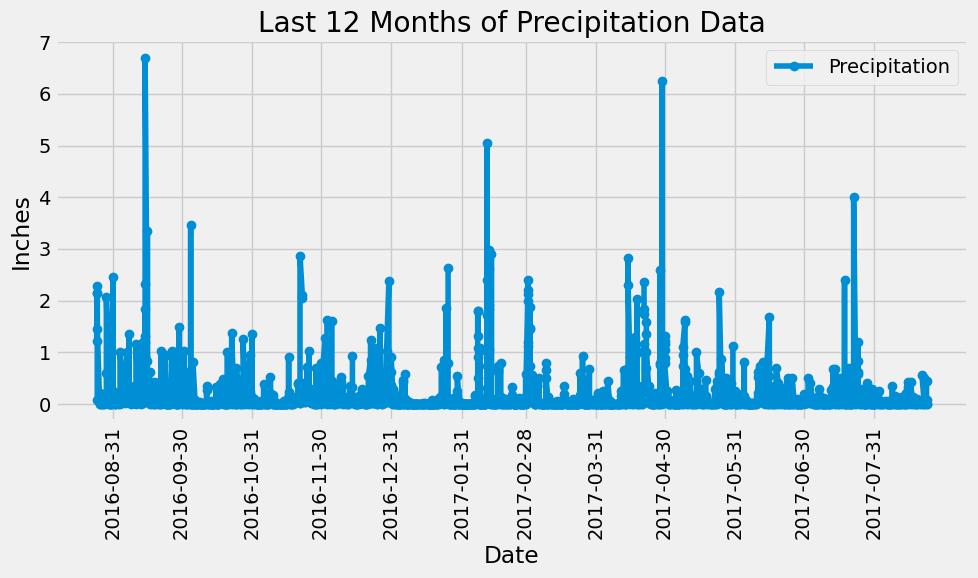

In [23]:
# Calculate the date one year from the last date in the dataset.
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores.
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame.
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data.
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', marker='o')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(pd.date_range(start=precipitation_df['Date'].min(), end=precipitation_df['Date'].max(), freq='M'), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()



In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f"Station ID: {station}, Count: {count}")


Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                                  func.max(Measurement.tobs).label('max_temp'),
                                  func.avg(Measurement.tobs).label('avg_temp')).\
    filter(Measurement.station == most_active_station).all()


min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"For the most active station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {min_temp} °F")
print(f"Highest Temperature: {max_temp} °F")
print(f"Average Temperature: {avg_temp} °F")


For the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


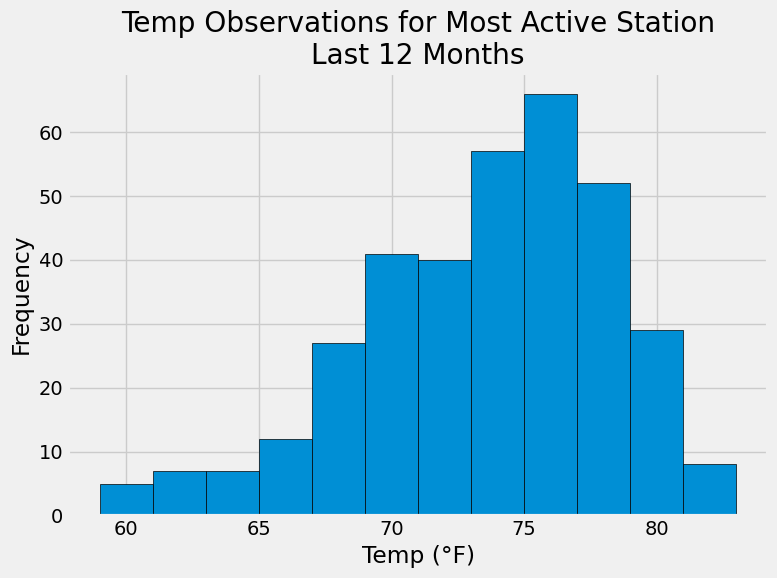

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temp (°F)')
plt.ylabel('Frequency')
plt.title(f'Temp Observations for Most Active Station\nLast 12 Months')
plt.tight_layout()
plt.show()


# Close Session

In [32]:
# Close Session
session.close()